In [21]:
import itertools

import matplotlib.pyplot as plt
import torch

from augmentation import AddGaussianNoise
from dataset import get_dataloaders_unsupervised
from train import transfer_knowledge
from unet import Unet

device = 'cuda'
model = Unet(layers=[8, 16, 32, 64, 128], output_channels=1).to(device)

model.load_state_dict(torch.load('learned_models/autoencoder/1e-4_10epochs.pt', map_location=device))
model.eval()

_, dataloader_train, _, dataloader_test = get_dataloaders_unsupervised(image_folder='projs', augmentations=AddGaussianNoise(std=0.5))

def plot_single(img):
    with torch.no_grad():
        fig, (ax1, ax2) = plt.subplots(1, 2)

        initial = img.cpu().numpy().squeeze()
        processed = torch.sigmoid(model(img)).cpu().numpy().squeeze()

        # print(initial.shape, processed.shape)

        ax1.imshow(initial)
        ax2.imshow(processed)
        plt.show()

In [22]:
samples = itertools.islice(dataloader_train, 10)

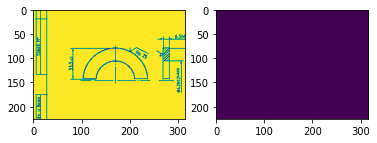

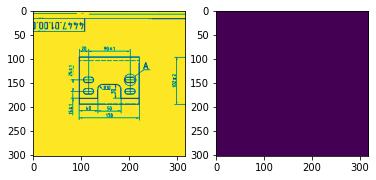

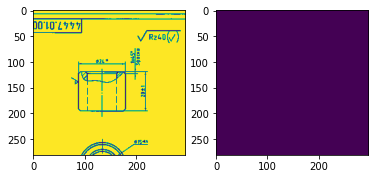

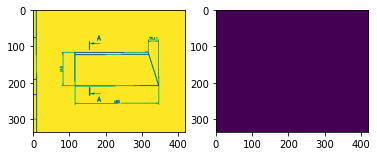

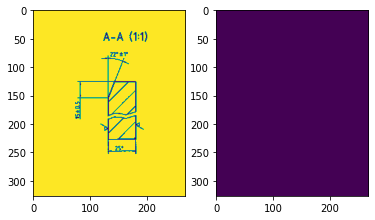

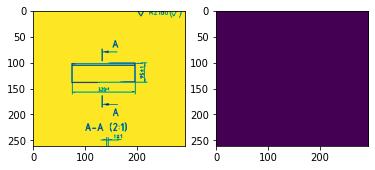

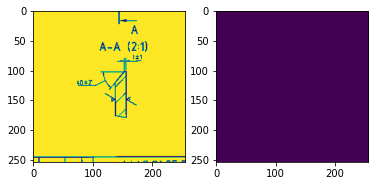

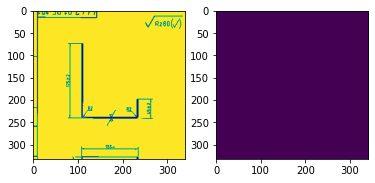

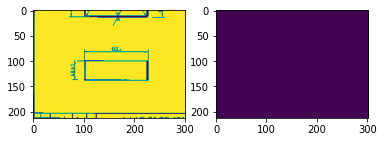

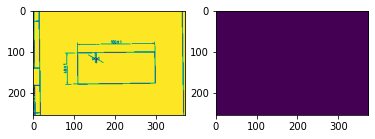

In [23]:
for img in samples:
    if isinstance(img, list):
        img, augmented = img

    # img = 255 - img

    plot_single(img.to(device))

In [90]:
def test_on_cats_and_blueprints():
    import matplotlib.pyplot as plt
    from PIL import Image
    import numpy as np
    from pathlib import Path
    import torch.nn as nn

    model = Unet(layers=[8, 16, 32, 64, 128], output_channels=1)
    transfer_knowledge(model, Path() / 'learned_models' / 'autoencoder'/ '1e-4_10epochs.pt')
    dataset_train, dataloader_train, dataset_test, dataloader_test = get_dataloaders_unsupervised(dpi=50)

    criterion = nn.MSELoss()

    model.eval()
    # img = next(iter(dataloader_train))
    img = torch.Tensor(np.array(Image.open('E:/acady/Desktop/83211.jpg').convert('L')).reshape([1, 1, 173, -1]))
    img_decoded = model(img)

    print(img.shape)
    print(img_decoded.shape)
    loss = criterion(img, img_decoded)
    print(loss)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[30, 20])
    a = ax1.imshow(img.squeeze())
    ax2.imshow(img_decoded.cpu().detach().numpy().squeeze())

    # img_decoded = img_decoded.cpu().detach().numpy().squeeze()
    # img_decoded = img_decoded.transpose(1, 2, 0)  # np.swapaxes(img_decoded, 0, 2)
    # img_decoded = np.uint8((img_decoded + np.min(img_decoded)) / (np.max(img_decoded) + np.min(img_decoded)) * 255)
    # Image.fromarray(img_decoded, 'RGB').show()

    # fig.colorbar(a, ax=fig)
    fig.suptitle(f'Shape: {img.shape} Loss: {loss}', fontsize=30)
    plt.show()
    # train_as_autoencoder(model, dataloader_train)

torch.Size([1, 1, 173, 105])
torch.Size([1, 1, 173, 105])
tensor(13009.7959, grad_fn=<MseLossBackward>)


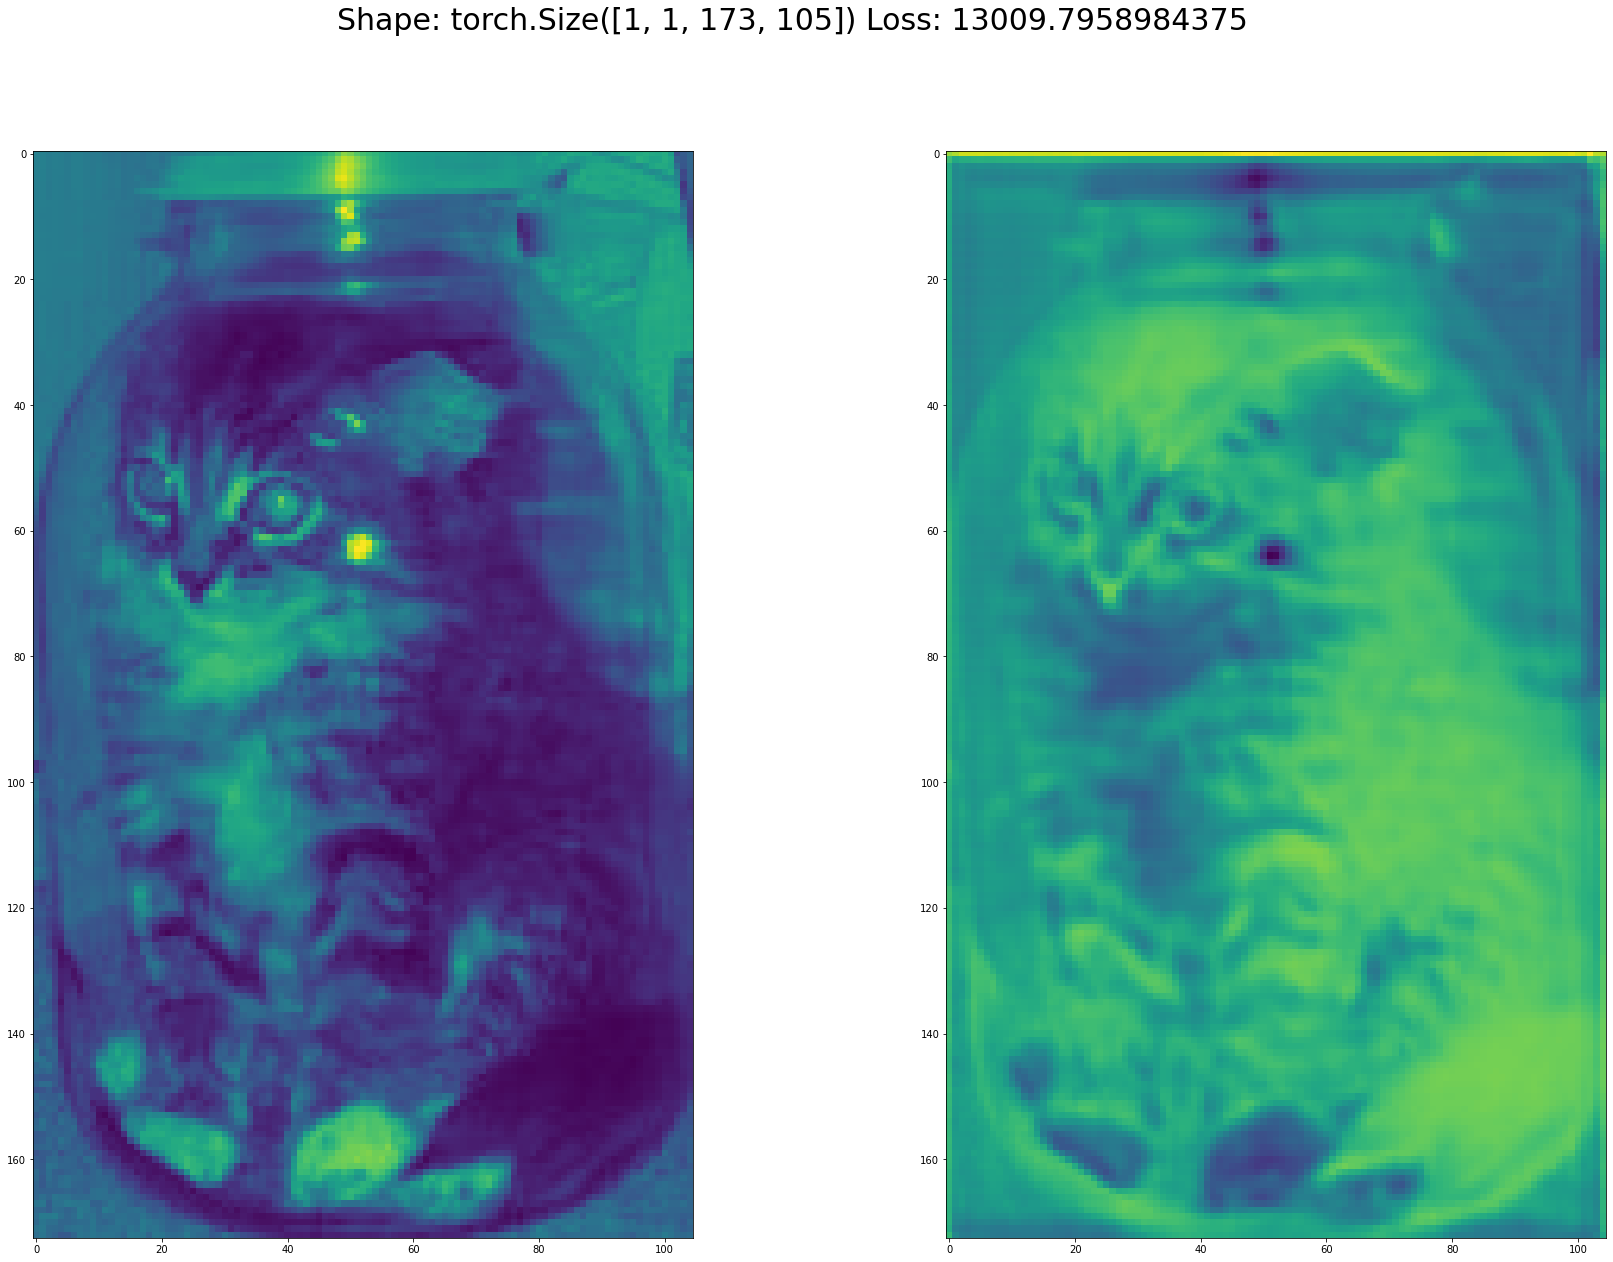

In [91]:
test_on_cats_and_blueprints()